## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
import os
os.environ['JAX_PLATFORM_NAME'] = 'cpu' 
from scipy.stats import norm, linregress
#from gpyrn import covfunc, meanfunc, meanfield
import exoplanet as xo
from scipy.optimize import minimize
from scipy.stats import norm
import csv
from scipy import stats
from multiprocessing import Pool
import emcee
import corner
from loguniform import LogUniform, ModifiedLogUniform
import sys
sys.path.append(os.path.abspath("/home/paul/Bureau/IRAP/TediGP"))
import process, kernels, means
from scipy import signal
from tqdm import tqdm
import pandas as pd


np.random.seed(110**2)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Load 2 first componant

In [2]:
eigen2vectors = np.load('/home/paul/Bureau/IRAP/dLWPCA/out/TablesAU_MIC/2firstcomponent.npy', allow_pickle=True) #### PATH TO CHANGE ####
times = np.load('/home/paul/Bureau/IRAP/dLWPCA/out/TablesAU_MIC/readyforwPCA_epoc.npy')                          #### PATH TO CHANGE ####

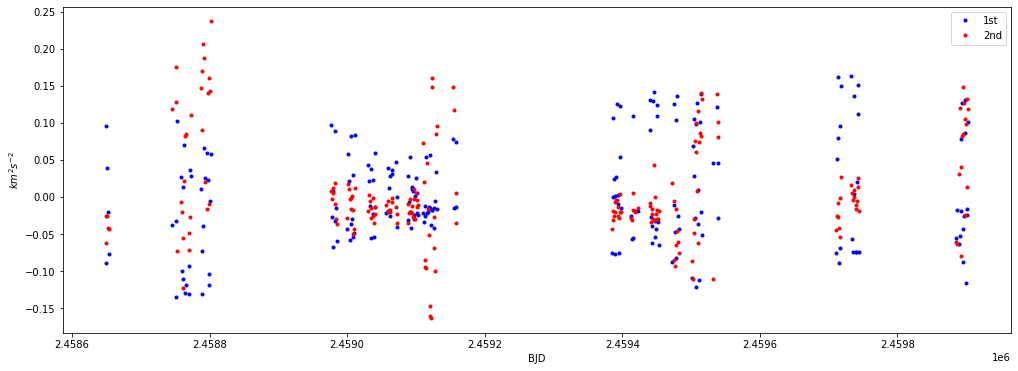

In [3]:
plt.figure(figsize=(17, 6))
plt.plot(times, eigen2vectors[0], 'b.', label='1st')
plt.plot(times, eigen2vectors[1], 'r.', label='2nd')
plt.xlabel('BJD')
plt.ylabel('$km^2 s^{-2}$')
plt.legend()
#plt.plot(times[:-1], eigen2vectors[3], 'r.')

plt.show()

## Periodograms
### 1st component

Peak frequency = 
4.872036928043502


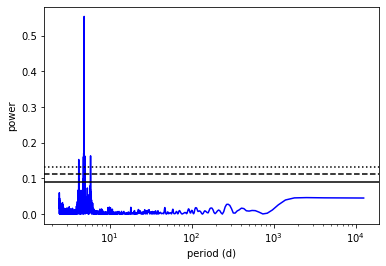

In [4]:
frequency, power = LombScargle(times, eigen2vectors[0]).autopower()
plt.figure(2)
plt.plot(1/frequency, power, 'b')
plt.xlabel("period (d)")
plt.ylabel("power")
plt.xscale('log')


peak_freq = 1 / frequency[np.argmax(power)]
print('Peak frequency = ')
print(peak_freq)

ls = LombScargle(times, eigen2vectors[0])

fap = ls.false_alarm_level(0.1)
plt.axhline(fap, linestyle='-', color='k')

fap = ls.false_alarm_level(0.01)
plt.axhline(fap, linestyle='--', color='k')

fap = ls.false_alarm_level(0.001)
plt.axhline(fap, linestyle=':', color='k')

plt.show()

### 2nd component

Peak frequency = 
379.87124290472514


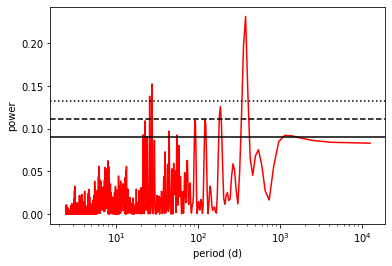

In [5]:
frequency, power = LombScargle(times, eigen2vectors[1]).autopower()
plt.figure(2)
plt.plot(1/frequency, power, 'r')
plt.xlabel("period (d)")
plt.ylabel("power")
plt.xscale('log')


peak_freq = 1 / frequency[np.argmax(power)]
print('Peak frequency = ')
print(peak_freq)

ls = LombScargle(times, eigen2vectors[1])

fap = ls.false_alarm_level(0.1)
plt.axhline(fap, linestyle='-', color='k')

fap = ls.false_alarm_level(0.01)
plt.axhline(fap, linestyle='--', color='k')

fap = ls.false_alarm_level(0.001)
plt.axhline(fap, linestyle=':', color='k')

plt.show()

## First component GP

Just to recall the GP uses a Quasi-Periodic covariance function that is build that way:


$K_{ij} = \eta_1^2 \, \exp \left[- \frac{(t_i - t_j)^2}{2 \eta_2^2} - \frac{2 }{\eta_4^2} \sin^2 \left( \frac{\pi (t_i - t_j)}{\eta_3} \right) \right] + Jitter$ 

In [12]:
print(2*(np.max(eigen2vectors[0])- np.min(eigen2vectors[0])))
print(np.std(eigen2vectors[0]))
print(10*(np.max(times)-np.min(times)))


0.5967559470595729
0.06943996753537869
12535.75101585593


For the Prior distribution, I use : 

$\eta_1 : \mathcal{MLU}\left( y_\sigma , 2 \times y_{ptp} \right)$

$\eta_2 : \mathcal{LU}\left( 1 , 10 \times t_{total} \right)$

$\eta_3 : \mathcal{N}\left( P , 0.1 \right)$

$\eta_4 : \mathcal{LU}\left( 0.1, 5 \right)$

$Jitter : \mathcal{MLU}\left( y_\sigma , 2 \times y_{ptp} \right)$

In [13]:
#Priors
n_eta1 = ModifiedLogUniform(0.07, 0.6)
n_eta2 = stats.loguniform(1, 12565)
n_eta3 = stats.norm(loc=4.865, scale=0.1)
n_eta4 = stats.loguniform(0.1, 5)
jitter = ModifiedLogUniform(0.07, 0.6)

In [14]:
def priors():
    return np.array([n_eta1.rvs(),n_eta2.rvs(), n_eta3.rvs(), n_eta4.rvs(), jitter.rvs()])

In [15]:
def logPosterior(HyperParam):
    n1,n2,n3,n4, j = HyperParam
    
    logprior = n_eta1.logpdf(n1)
    logprior += n_eta2.logpdf(n2)
    logprior += n_eta3.logpdf(n3)
    logprior += n_eta4.logpdf(n4)
    logprior += jitter.logpdf(j)
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(eigen2vectors[0]))
    gpOBJ = process.GP(kernel,mean,times,eigen2vectors[0], yerr = 1e-12 * np.identity(times.size))
    
    logposterior = gpOBJ.log_likelihood() + logprior
    return logposterior

In [16]:
ndim = priors().size 
nwalkers = 2*ndim

In [17]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior)
p0=[priors() for i in range(nwalkers)]
sampler.run_mcmc(p0, 10000, progress=True)

100%|██████████| 10000/10000 [06:08<00:00, 27.12it/s]


State([[6.95961467e-02 1.41935415e+02 4.86452175e+00 9.02257494e-01
  8.77731430e-03]
 [6.87673640e-02 1.45110221e+02 4.85845102e+00 8.83825632e-01
  7.12645099e-03]
 [5.99316694e-02 1.49940007e+02 4.86132521e+00 8.18093398e-01
  6.93341195e-03]
 [7.01455142e-02 1.45600233e+02 4.86486404e+00 8.11982284e-01
  6.61704992e-03]
 [5.81985398e-02 1.32749581e+02 4.85712477e+00 6.62340710e-01
  6.90095900e-03]
 [6.53756441e-02 1.56910340e+02 4.85961311e+00 8.50524276e-01
  8.89629704e-03]
 [6.17409289e-02 1.53487535e+02 4.86495230e+00 8.36251425e-01
  7.59418181e-03]
 [6.75518500e-02 1.43593264e+02 4.86396990e+00 9.26687178e-01
  7.67249947e-03]
 [6.26849278e-02 1.63572013e+02 4.86313055e+00 7.22018856e-01
  8.14810390e-03]
 [6.44463994e-02 1.50487738e+02 4.85898281e+00 9.65295480e-01
  8.74433384e-03]], log_prob=[567.66760532 569.26356    569.61001784 567.99869027 564.37739379
 567.54924929 569.68490829 570.08007825 568.3533698  565.75310066], blobs=None, random_state=('MT19937', array([16756

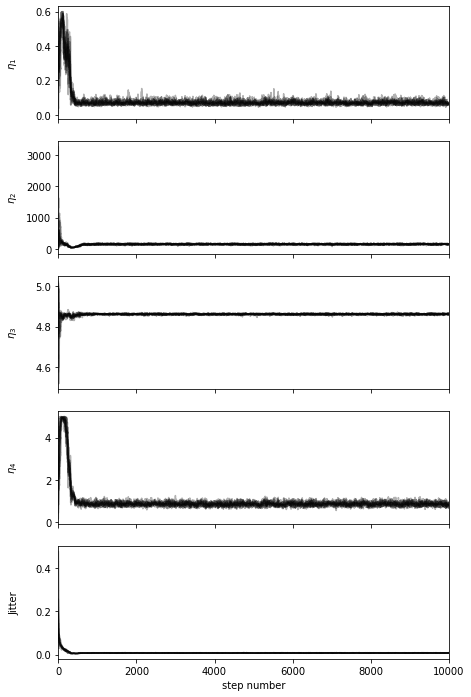

In [18]:
#chains plot
fig, axes = plt.subplots(5, figsize=(7, 12), sharex=True)
samples = sampler.get_chain()
labels = ["$\eta_1$", "$\eta_2$", "$\eta_3$", "$\eta_4$", "Jitter"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.show()

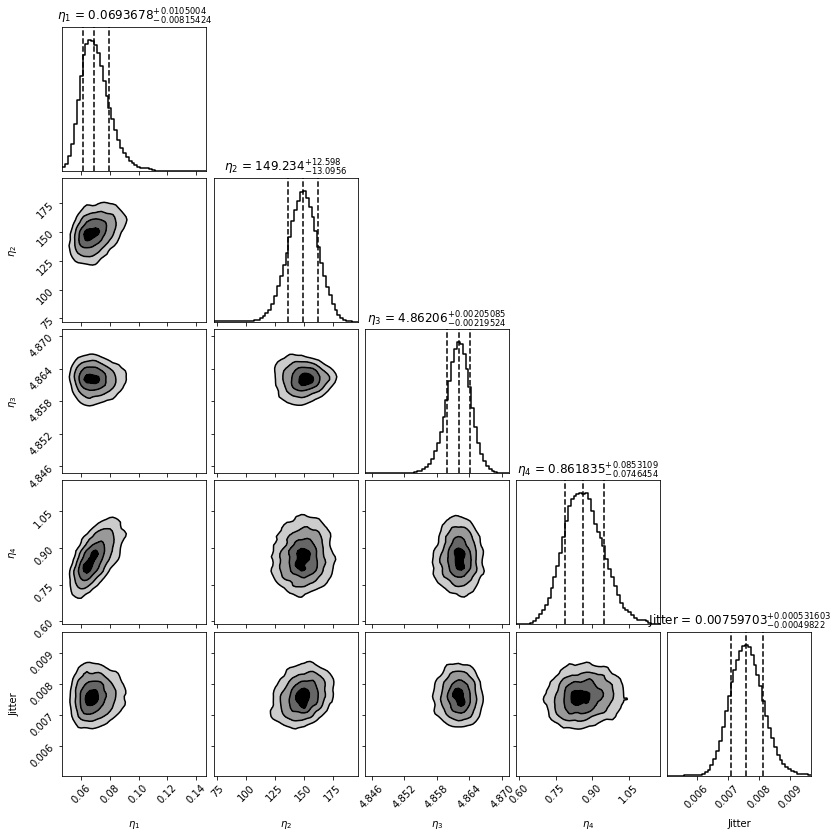

In [19]:
#corner plot
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
fig = corner.corner(flat_samples,labels=labels, color="k", bins = 50,
                    quantiles=[0.16, 0.5, 0.84], smooth=True, smooth1d=True, 
                    show_titles=True, plot_density=True, plot_contours=True,
                    fill_contours=True, plot_datapoints=False, title_fmt='g')
plt.show()

In [20]:
def Display(HyperParam, tplot):
    n1,n2,n3,n4, j = HyperParam
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(eigen2vectors[0]))
    gpOBJ = process.GP(kernel,mean,times,eigen2vectors[0],yerr = 1e-12 * np.identity(times.size))
    
    y_mean, y_std, time = gpOBJ.prediction(kernel,mean,tplot)
    return y_mean

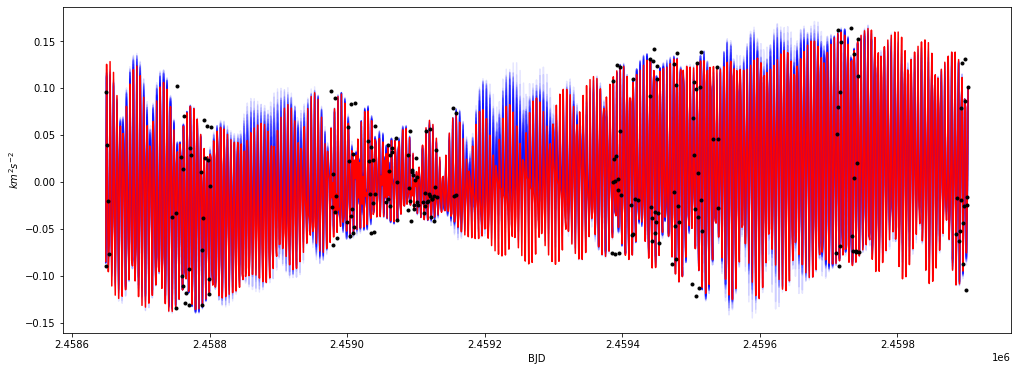

In [22]:
plt.figure(figsize=(17, 6))
tplot = np.linspace(np.min(times), np.max(times), 1000)

for s in range(25):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.1)
Hfit = np.median(sampler.flatchain, axis=0)
plt.plot(tplot, Display(Hfit, tplot), 'r')
plt.plot(times, eigen2vectors[0],'k.')
plt.xlabel('BJD')
plt.ylabel('$km^2 s^{-2}$')
plt.show()

100%|██████████| 15/15 [01:30<00:00,  6.04s/it]


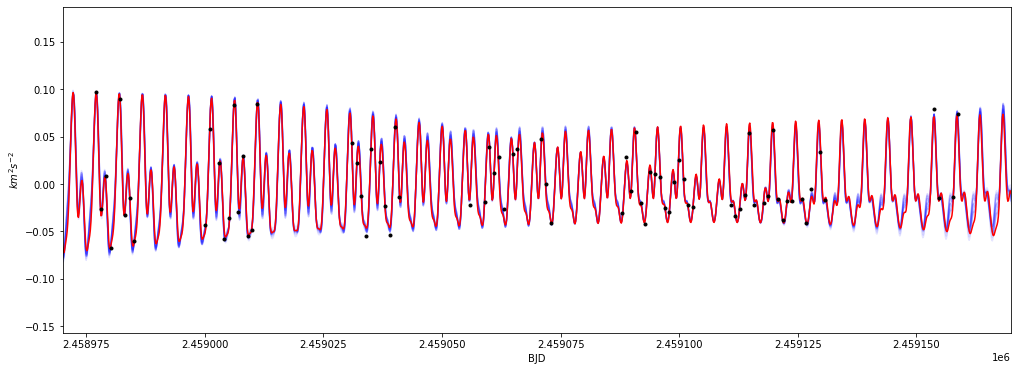

In [23]:
plt.figure(figsize=(17, 6))
tplot = np.linspace(np.min(times), np.max(times), 10000)

for s in tqdm(range(15)):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.1)
Hfit = np.median(sampler.flatchain, axis=0)
plt.plot(tplot, Display(Hfit, tplot), 'r')
plt.plot(times, eigen2vectors[0],'k.')
plt.xlim([-30+2459000, 170+2459000])
plt.xlabel('BJD')
plt.ylabel('$km^2 s^{-2}$')
plt.show()

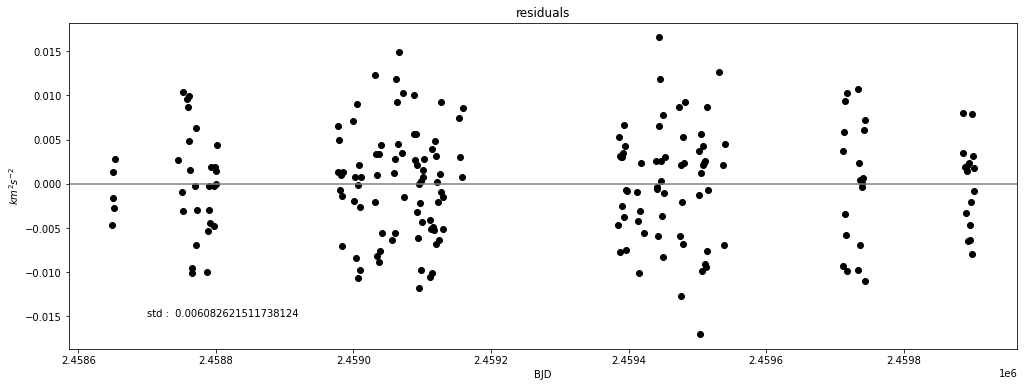

In [25]:
y_sample = Display(Hfit, times)

residuals = eigen2vectors[0] - y_sample
plt.figure(figsize=(17, 6))
plt.plot(times, residuals, 'ok')
plt.axhline(y=0, c='grey')
plt.annotate( "std :  " + str(np.std(residuals)), (2.4587*1e6, -0.015) )
plt.title('residuals')
plt.xlabel('BJD')
plt.ylabel('$km^2 s^{-2}$')
plt.show()